Read in fluxnet data for stations over a specified longitude and latitude range and only for stationss that have >= 10 years worth of data.

In [1]:
import importlib
import xarray as xr
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
from math import nan
import math
from glob import glob

from CASutils import mapplot_utils as maps

importlib.reload(maps)

<module 'CASutils.mapplot_utils' from '/home/islas/python/CASanalysis/CASutils/mapplot_utils.py'>

set locations of fluxnet data and output directory

In [2]:
datdir="/project/mojave/observations/FLUXNET2015/"
outdir="/project/cas/islas/python_savs/fluxnet/"

read in station info

In [3]:
stationinfo = pd.read_csv(datdir+"SiteList.csv")

specify longitude and latitude range under consideration

In [ ]:
stationinfonh = stationinfo.loc[ ((stationinfo.LOCATION_LAT > 40) & (stationinfo.LOCATION_LONG < -55)) | ((stationinfo.LOCATION_LAT > 45) & (stationinfo.LOCATION_LONG > 30))]

In [6]:
stationuse = []
lonuse = []
latuse = []
count=0
for index, station in stationinfonh['SITE_ID'].iteritems():
    fname = glob(datdir+'*'+station+'*/*DD*')

    try:
        data = pd.read_csv(fname[0])
        ybeg = str(data[['TIMESTAMP']].iloc[0].values)[1:5]
        yend = str(data[['TIMESTAMP']].iloc[len(data[['TIMESTAMP']])-1].values)[1:5]
        nyears = int(yend)-int(ybeg)+1
        if (nyears >= 10):
            try:
                # check for necessary variables
                data = data[['TIMESTAMP','TA_F','TA_F_QC','H_F_MDS','H_F_MDS_QC','G_F_MDS','G_F_MDS_QC','NETRAD','NETRAD_QC']]
                print(station+' '+str(nyears))
                stationuse.append(station)
                lonuse.append(stationinfonh.loc[index, 'LOCATION_LONG'])
                latuse.append(stationinfonh.loc[index, 'LOCATION_LAT'])
            except:
                pass
    except:
        pass

CA-Gro 12
CA-Man 15
CA-Oas 15
CA-Obs 14
CA-TP1 13
CA-TP3 13
CA-TP4 13
RU-Cok 12
RU-Fyo 17
US-GLE 11
US-Ha1 22
US-Los 15
US-Me2 13
US-NR1 17
US-Ne2 13
US-Ne3 13
US-Oho 10
US-Syv 14
US-UMB 15
US-WCr 16


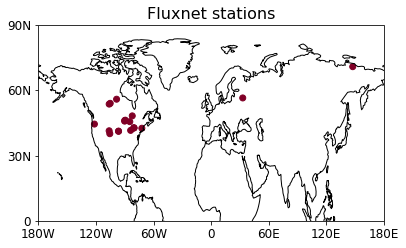

In [7]:
fig = plt.figure(figsize=(16,16))

ax1 = maps.contourmap_bothcontinents_scatter_nh_pos(fig, np.ones([len(lonuse)]), lonuse, latuse, 0.1,-1,1,'Fluxnet stations',
                                                   0.02,0.32,0.8,0.97)

In [8]:
# Read in the data for stations that will be used.
count=0
for istation in stationuse:
    fname = glob(datdir+'*'+istation+'*/*DD*')
    data = pd.read_csv(fname[0])
    data = data[['TIMESTAMP','TA_F','TA_F_QC','H_F_MDS','H_F_MDS_QC','G_F_MDS','G_F_MDS_QC','NETRAD','NETRAD_QC']]
    ybeg = str(data[['TIMESTAMP']].iloc[0].values)[1:5]
    yend = str(data[['TIMESTAMP']].iloc[len(data[['TIMESTAMP']])-1].values)[1:5]
    timeout = pd.date_range(start=ybeg+"-01-01", end=yend+"-12-31")
    timeoutasdata = [str(timeout[i].year)+str(timeout[i].month).zfill(2)+str(timeout[i].day).zfill(2) for i in np.arange(0,len(timeout),1)]
    timeoutasdata = [int(i) for i in timeoutasdata]  
    
    tas = np.empty([len(timeoutasdata)]) ; tas_qc = np.empty([len(timeoutasdata)])
    shflx = np.empty([len(timeoutasdata)]) ; shflx_qc = np.empty([len(timeoutasdata)])
    g = np.empty([len(timeoutasdata)]) ; g_qc = np.empty([len(timeoutasdata)])
    netrad = np.empty([len(timeoutasdata)]) ; netrad_qc = np.empty([len(timeoutasdata)])
    
    tas[:] = nan ; tas_qc[:] = nan
    shflx[:] = nan ; shflx_qc[:] = nan
    g[:] = nan ; g_qc[:] =  nan
    netrad[:] = nan ; netrad_qc[:] = nan
    
    # find the dates that exist in the file and assign to the right place in the output array
    datesinds = dict()
    for i, j in enumerate(timeoutasdata):
        datesinds.setdefault(j,[]).append(i)        
    res = [datesinds.get(i,[None]) for i in data['TIMESTAMP']]
    
    shflx[np.array(res).squeeze()] = data['H_F_MDS']
    tas[np.array(res).squeeze()] = data['TA_F']
    tas_qc[np.array(res).squeeze()] = data['TA_F_QC']
    g[np.array(res).squeeze()] = data['G_F_MDS']   
    g_qc[np.array(res).squeeze()] = data['G_F_MDS_QC']
    shflx_qc[np.array(res).squeeze()] = data['H_F_MDS_QC']
    netrad[np.array(res).squeeze()] = data['NETRAD']
    netrad_qc[np.array(res).squeeze()] = data['NETRAD_QC']    

    lon_xr = xr.DataArray(np.array(lonuse[count]), name='lon')
    lat_xr = xr.DataArray(np.array(latuse[count]), name='lat')
    shflx_xr = xr.DataArray(np.array(shflx), coords=[timeout], dims=['time'], name='shflx')
    tas_xr = xr.DataArray(np.array(tas), coords=[timeout], dims=['time'], name='tas')
    g_xr = xr.DataArray(np.array(g), coords=[timeout], dims=['time'], name='g')
    netrad_xr = xr.DataArray(np.array(netrad), coords=[timeout], dims=['time'], name='netrad')
    
    shflx_qc_xr = xr.DataArray(np.array(shflx_qc), coords=[timeout], dims=['time'], name='shflx_qc')
    tas_qc_xr = xr.DataArray(np.array(tas_qc), coords=[timeout], dims=['time'], name='tas_qc')
    g_qc_xr = xr.DataArray(np.array(g_qc), coords=[timeout], dims=['time'], name='g_qc')
    netrad_qc_xr = xr.DataArray(np.array(netrad_qc), coords=[timeout], dims=['time'], name='netrad_qc')
    
    shflx_xr.to_netcdf(path=outdir+istation+".nc")
    tas_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    g_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    netrad_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    netrad_qc_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    shflx_qc_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    tas_qc_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    g_qc_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    lon_xr.to_netcdf(path=outdir+istation+".nc", mode="a")
    lat_xr.to_netcdf(path=outdir+istation+".nc", mode="a")  
    
    count=count+1